In [1]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import geopandas as gpd
from shapely.geometry import shape, Point
import collections
from scipy.stats.mstats import zscore

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import the list of selected images from the fringes of the
The images are saved inthe picke file as a touple of key and dictionary
a sample is here 
('50f5ed56fdc9f065f0008c3c',
 {'key': '50f5ed56fdc9f065f0008c3c',
  'label': 1,
  'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/50f5ed56fdc9f065f0008c3c.jpg',
  'trueSkill': [34.40761521557218]}
 )

In [3]:
# ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImages.pkl"
#Uncomment for 1000 sample images
# ImageList = "/datasets_1/sagarj/BellLabs/Data/fringeImagesBottomUp.pkl"

#Uncomment for Boston
ImageList = "/datasets_1/sagarj/BellLabs/Data/bostonDf.pkl"



#urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/"
#ImageList = "/datasets_1/sagarj/BellLabs/Data/mediumImages.pkl"
with open(ImageList , 'rb') as f:
    imgList = pickle.load(f)

In [4]:
len(imgList)

127

In [5]:
datasetImageCoords = "/datasets_1/sagarj/BellLabs/Data/AllStreetScoreImageLocs.pkl"

In [6]:
with open(datasetImageCoords,'rb') as f:
    imgCoords = pickle.load(file=f)

In [7]:
type(imgCoords[imgCoords.keys()[1]])

shapely.geometry.point.Point

In [8]:
imgLocDict = {}
for i in imgCoords:
    imgLocDict[i] = dict()
    imgLocDict[i]['Lat'] = imgCoords[i].y
    imgLocDict[i]['Long'] = imgCoords[i].x
    

In [9]:
# with open("allImageLocs.json", 'wb') as f:
#     json.dump(imgLocDict,f)

In [10]:
usa = gpd.read_file("../shapeFiles/cb_2016_us_ua10_500k.shp")

In [11]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [321]:
usa[usa['NAME10'] == 'Boston']

,AFFGEOID10,ALAND10,AWATER10,GEOID10,LSAD10,NAME10,UACE10,UATYP10,geometry


In [12]:
us_selected_poly = ['Boston, MA--NH--RI']
bos_poly = [usa[(usa['NAME10'] == k)]['geometry'] for k in us_selected_poly]

In [13]:
bos_poly

[1283    (POLYGON ((-70.861812 42.658277, -70.860432 42...
 Name: geometry, dtype: object]

In [14]:
bostonImages = {}
for k in imgCoords:
     if checkPoly(Point(imgCoords[k].x , imgCoords[k].y),bos_poly):
            #print "Found one"
            bostonImages[k] = imgCoords[k]

In [15]:
len(bostonImages)

1332

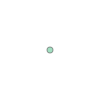

In [16]:
bostonImages[bostonImages.keys()[1]]

In [17]:
len(imgList)

127

In [20]:
# imgList[10]

In [19]:
# len(list(set(imgList.keys()).intersection(set(bostonImages.keys()))))

In [22]:
# ugliestImgs = {}
# for k in imgList:
#     if k[1]['trueSkill'] > 30:
#         print "found"
#         ugliestImgs[k[0]] = imgList[k]

In [23]:
len(ugliestImgs)

0

Directory path to the list of sampled transformed images

In [24]:
# AMImages = "/datasets/sagarj/streetView/Transform_1000/"
AMImages = "/datasets/sagarj/streetView/Transform_Boston150/"
#AMImages = "/datasets/sagarj/streetView/Transform_Medium/"

In [25]:
files = os.listdir(AMImages)

In [26]:
files[1].split('_')

['513d676efdc9f03587004089', '0001', '0.451787', '.jpg']

In [27]:
filesMap = {}
for f in files:
    comps = f.strip().split('_')
    filesMap[comps[0]] = {}
    filesMap[comps[0]]['path'] = AMImages + f
    filesMap[comps[0]]['act'] = comps[2]
    filesMap[comps[0]]['changeLabel'] = comps[1][-1]

In [28]:
len(filesMap.keys())

127

In [29]:
##imgList['513d686efdc9f03587004381']

In [31]:
#Uncomment this for boston
for row in imgList:
    if imgList[row][1]['key'] in filesMap.keys():
        filesMap[imgList[row][1]['key']]['origPath'] = imgList[row][1]['path']
        filesMap[imgList[row][1]['key']]['label'] = imgList[row][1]['label']

In [32]:
##Uncomment this for All images
# for row in imgList:
#     if row[1]['key'] in filesMap.keys():
#         filesMap[row[1]['key']]['origPath'] = row[1]['path']
#         filesMap[row[1]['key']]['label'] = row[1]['label']

In [33]:
filesMap[filesMap.keys()[1]]

{'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg'}

### The above code created a files map as seen below which makes a single data structure which has 
* transformation final activation 
* the label of the class to which the image was transformed into (1 = beauty , 0 = ugly)
* original label
* original path of the un transformed image 
* Path to the synthesized image

In [34]:
# filesMap['513d686efdc9f03587004381']

In [35]:
# Image(filesMap['513d9f45fdc9f035870086b4']['origPath'])

In [36]:
#Image(filesMap['513d9f45fdc9f035870086b4']['path'])

In [37]:
#filesMap['513d9f45fdc9f035870086b4']['changeLabel']

### The below code is a feature extraction code that uses PlacesNet CNN to extract the last but one fully connected layer which is a 4096 dimensional vector

#### the block has 
* A code to transform the image to a consumable size 
* A block that extracts the 4096 dimensional features
* A block that actually returns the top 5 Places labels (Used for measurement)

In [38]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(DataDict):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    for k in DataDict:
        path = DataDict[k]['path'].strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,4096))
        else:
            im = transformer.preprocess('data',caffe.io.load_image(path))
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['fc7'].data.copy()
                
        DataDict[k]['placesFeats'] = featArray
    return DataDict

def getPlaces(path):
    caffe.set_mode_gpu()    
    model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    feats = {}
    path = path.strip()
    if not os.path.exists(path):
        featArray = np.zeros((1,4096))
    else:
        im = transformer.preprocess('data',caffe.io.load_image(path))
        net.blobs['data'].data[...] = im - meanMat
        net.forward()
        featArray = net.blobs['prob'].data.copy()
    return featArray

/work/sagarj/Work/caffe-fr-chairs/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/work/sagarj/Work/caffe-fr-chairs/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/work/sagarj/Work/caffe-fr-chairs/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [39]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

### The getFeatMatrix function edits the dictionary in place and adds the features as a part of FilesMap dictionary created before

In [40]:
transformedFilesMap = getFeatMatrix(filesMap)

In [41]:
transformedFilesMap[transformedFilesMap.keys()[120]]

{'act': '0.47995',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6bc3fdc9f03587004dcc.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d6bc3fdc9f03587004dcc_0001_0.47995_.jpg',
 'placesFeats': array([[0.32846552, 0.        , 0.2208575 , ..., 0.44977036, 0.7499724 ,
         0.04764497]], dtype=float32)}

# This is an extremely shitty part of the code. The crux is you need the test data in a key : dict{} format where the dict should have a 'origPath' entry with the path of the test image which we are retrevi

In [42]:
# with open("../Data/TrainImageListBinary_augmented.txt",'r') as f:
#     imagePaths = f.readlines()

In [43]:
# len(imagePaths)

In [44]:
# sampledpaths = random.sample(imagePaths , 5000)

In [45]:
# sampledpaths[1]

In [46]:
# sampledPathsDict = {}
# for f in sampledpaths:
#     comps = f.strip().split(',')
#     lbl = comps[1]
#     imgID = comps[0].split('/')[-1].split('.')[0]
#     sampledPathsDict[imgID] = {}
#     sampledPathsDict[imgID]['origPath'] = comps[0]
#     sampledPathsDict[imgID]['label'] = lbl

In [47]:
# sampledPathsDict[sampledPathsDict.keys()[100]]

In [48]:
# with open("../Data/sampledSegnetImages.pkl",'wb') as f:
#     pickle.dump(sampledPathsDict,f,protocol=pickle.HIGHEST_PROTOCOL)

# sampledSegnetImages.pkl is a file used for measurement to analyse segnet zones in an image
### After saving the disctionay, you will need to run the segnet extraction script externally. Halt at this point



In [49]:
#Image dataset (Pool of images to match from) 
with open('/datasets_1/sagarj/BellLabs/Data/bostonAllSegnet.pkl', 'rb') as handle:
    testSegnetLabels = pickle.load(handle)
    
#Uncomment this for test data of 1000 images
# with open('../Data/testSegnetFeatures.pkl', 'rb') as handle:
#     testSegnetLabels = pickle.load(handle)


#with open('../Data/retrievalSegnetLabelsTextures.pkl', 'rb') as handle:
#    segnetLabels = pickle.load(handle)

#Root images which are being transformed 
# with open('../Data/fringe1000SegnetFeatures.pkl', 'rb') as handle:
#     segnetLabels = pickle.load(handle)

with open('/datasets_1/sagarj/BellLabs/Data/bostonUglySegnet.pkl', 'rb') as handle:
    segnetLabels = pickle.load(handle)


In [50]:
print len(testSegnetLabels.keys()), len(segnetLabels.keys())

774 127


In [51]:
testSegnetLabels[testSegnetLabels.keys()[1]]

{'segnetLabels': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [4., 7., 9., ..., 4., 4., 4.],
        [1., 1., 9., ..., 4., 4., 4.],
        [1., 1., 4., ..., 4., 4., 4.]], dtype=float32)}

In [52]:
allImagesToShare = list(set(testSegnetLabels.keys()).union(set(segnetLabels.keys())))

In [53]:
# segnetLabels[segnetLabels.keys()[1]]

In [55]:
with open('../Data/bostonAllFringe.pkl', 'rb') as handle:
    testImages = pickle.load(handle)
    
    
# with open('../Data/testImages.pkl', 'rb') as handle:
#     testImages = pickle.load(handle)

In [56]:
len(testImages)

774

In [66]:
#Uncomment for boston
testKeys = [testImages[i][1]['key']  for i in testImages]

#Uncomment for 1000 images  
# testKeys = [i[1]['key']  for i in testImages]

transformedKeys = [k for k in filesMap]

In [67]:
len(testKeys)

774

In [68]:
common = [k for k in transformedKeys if k in testKeys]

In [70]:
len(common)

79

In [71]:
filteredTestImages = []
for k in testImages:
    if k[0] not in common:
        filteredTestImages.append(k)

In [72]:
filteredTestImages[1]

'513d67e8fdc9f035870041c2'

In [73]:
# Uncomment this for Boston
dataFileMap = {}
for p in filteredTestImages:
    path = testImages[p][1]['path']
    key = testImages[p][1]['key']
    dataFileMap[key] = {}
    dataFileMap[key]['path'] = path

In [74]:
#Uncomment this for the 1000 images

# dataFileMap = {}
# for p in filteredTestImages:
#     path = p[1]['path']
#     key = p[1]['key']
#     dataFileMap[key] = {}
#     dataFileMap[key]['path'] = path

In [75]:
dataFileMap[dataFileMap.keys()[1]]

{'path': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b62fdc9f03587004ce4.jpg'}

## Extract Places Fc6 features from Test images for further retrieval code

In [76]:
retreivalFileMap = getFeatMatrix(dataFileMap)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# End shitty zone now. the next sections are about matching

Here we find pairwise distances between transformed images and images from dataset.

In [77]:
filesMap[filesMap.keys()[1]]

{'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg',
 'placesFeats': array([[0.41810745, 0.11022174, 0.        , ..., 0.59241843, 0.54558194,
         0.        ]], dtype=float32)}

In [78]:
for k in filesMap:
    if k in segnetLabels:
        pixelcounts = collections.Counter(np.squeeze(segnetLabels[k]['segnetLabels']).flatten())
        filesMap[k]['segnet'] = {}
        denom = segnetLabels[k]['segnetLabels'].shape[0]*segnetLabels[k]['segnetLabels'].shape[1]
        for r in pixelcounts:
            filesMap[k]['segnet'][r] = float(pixelcounts[r])/float(denom)

        

In [79]:
for k in retreivalFileMap:
    if k in testSegnetLabels:
        pixelcounts = collections.Counter(np.squeeze(testSegnetLabels[k]['segnetLabels']).flatten())
        retreivalFileMap[k]['segnet'] = {}
        denom = testSegnetLabels[k]['segnetLabels'].shape[0]*testSegnetLabels[k]['segnetLabels'].shape[1]
        for r in pixelcounts:
            retreivalFileMap[k]['segnet'][r] = float(pixelcounts[r])/float(denom)


In [80]:
print len(filesMap.keys()), len(retreivalFileMap.keys())

127 774


In [81]:
len(set(filesMap.keys()).intersection(set(retreivalFileMap.keys())))

79

In [82]:
AllImageLocs = imgCoords

In [83]:
def lockDownDistanceFunction(src, dst):
    labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
    #features to lock
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but trees
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0 ] #Everything but Mobility
    #lockDownRatios = [ 0.0 , 1.0 , 3.0 , 4.0 , 6.0, 9.0 , 10.0 , 11.0 ] #Everything but ROAD SIDES
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 5.0 , 6.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Roads
    #lockDownRatios = [ 0.0 , 2.0 , 3.0 , 4.0 , 5.0 ,6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Buildings
    #lockDownRatios = [ 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Sky
    lockDownRatios = [] # Everything unlocked
    ##Tolerance levels in normalized ratios
    tol = 0.1
    for obj in lockDownRatios:
        if obj in src['segnet']:
            if obj not in dst['segnet']:
                return float('inf')
            if dst['segnet'][obj] > (src['segnet'][obj]+tol) or dst['segnet'][obj] < (src['segnet'][obj]-tol) :
                return float('inf')
    return distance.euclidean(dst['placesFeats'] , src['placesFeats'])
    

In [84]:
def lockDownCosineDistanceFunction(src, dst):
    labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
    #features to lock
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but trees
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0 ] #Everything but Mobility
    #lockDownRatios = [ 0.0 , 1.0 , 3.0 , 4.0 , 6.0, 9.0 , 10.0 , 11.0 ] #Everything but ROAD SIDES
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 5.0 , 6.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Roads
    #lockDownRatios = [ 0.0 , 2.0 , 3.0 , 4.0 , 5.0 ,6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Buildings
    #lockDownRatios = [ 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Sky
    lockDownRatios = [] # Everything unlocked
    ##Tolerance levels in normalized ratios
    tol = 0.1
    for obj in lockDownRatios:
        if obj in src['segnet']:
            if obj not in dst['segnet']:
                return float('inf')
            if dst['segnet'][obj] > (src['segnet'][obj]+tol) or dst['segnet'][obj] < (src['segnet'][obj]-tol) :
                return float('inf')
    return distance.cosine(dst['placesFeats'] , src['placesFeats'])
    

In [85]:
def lockDownCosineDistanceProximityDiscounted(src, dst):
    labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
    #features to lock
    lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but trees
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0 ] #Everything but Mobility
    #lockDownRatios = [ 0.0 , 1.0 , 3.0 , 4.0 , 6.0, 9.0 , 10.0 , 11.0 ] #Everything but ROAD SIDES
    #lockDownRatios = [ 0.0 , 1.0 , 2.0 , 5.0 , 6.0 , 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Roads
    #lockDownRatios = [ 0.0 , 2.0 , 3.0 , 4.0 , 5.0 ,6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Buildings
    #lockDownRatios = [ 1.0 , 2.0 , 3.0 , 4.0 , 5.0 , 6.0, 7.0 , 8.0 , 9.0 , 10.0 , 11.0 ] #Everything but Sky
    #lockDownRatios = [] # Everything unlocked
    ##Tolerance levels in normalized ratios
    tol = 0.1
    for obj in lockDownRatios:
        if obj in src['segnet']:
            if obj not in dst['segnet']:
                return float('inf')
            if dst['segnet'][obj] > (src['segnet'][obj]+tol) or dst['segnet'][obj] < (src['segnet'][obj]-tol) :
                return float('inf')
    dist = distance.cosine(dst['placesFeats'] , src['placesFeats'])
    

In [86]:
from scipy.spatial import distance
distanceMapper = {}
for k in filesMap:
    distanceMapper[k] = {}
    for i in retreivalFileMap:
        #distanceMapper[k][i] = angle_between(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        #distanceMapper[k][i] = distance.euclidean(filesMap[k]['placesFeats'] , retreivalFileMap[i]['placesFeats'])
        
        ##This distance function locks down feature areas in an image
        distanceMapper[k][i] = lockDownCosineDistanceFunction(filesMap[k] , retreivalFileMap[i])

In [87]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [88]:
AllFilesDict = merge_two_dicts(filesMap.copy() , retreivalFileMap.copy())
len(AllFilesDict)

822

In [89]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]

In [90]:
# Uncomment for 1000 Images
mapper = {'W':'Walkable' , 'L' : 'Landmark' , 'A' : 'Architectural' , 'N' : 'Natural' }
for k in AllFilesDict:
    print "processing : " + k
    arr = getPlaces(AllFilesDict[k]['path'])
    probs = np.squeeze(arr)
    topArgs = probs.argsort()[-5:][::-1]
    labelList = []
    TnomyCount = {'Walkable' : 0 , 'Landmark': 0 , 'Architectural' : 0 , 'Natural' : 0}
    for i in topArgs:
        key = str(i)
        if catDict[key]['tnomy'] != '':
            tnomy = catDict[key]['tnomy']
            TnomyCount[mapper[tnomy]]+=1
        labelList.append(catDict[key]['label'])
    AllFilesDict[k]['Top5PlaceLabels'] = labelList
    AllFilesDict[k]['TnomyScores'] = dict()
    AllFilesDict[k]['TnomyScores'] = TnomyCount
    
            

processing : 513d67e8fdc9f035870041c2
processing : 513d6b62fdc9f03587004ce4
processing : 513d6a1ffdc9f03587004978
processing : 513d6a72fdc9f03587004a7f
processing : 513d6ad3fdc9f03587004b7e
processing : 513d67e2fdc9f035870041b3
processing : 513d6c86fdc9f03587004fb6
processing : 513d6ca3fdc9f03587005004
processing : 513d6c47fdc9f03587004f1e
processing : 513d6911fdc9f035870045c9
processing : 513d6b2efdc9f03587004c6d
processing : 513d676efdc9f03587004089
processing : 513d6927fdc9f03587004622
processing : 513d6c2ffdc9f03587004ee2
processing : 513d69b8fdc9f0358700481f
processing : 513d687afdc9f035870043ad
processing : 513d6b99fdc9f03587004d6c
processing : 513d69a8fdc9f035870047e9
processing : 513d6833fdc9f035870042b1
processing : 513d6a46fdc9f035870049ff
processing : 513d6975fdc9f03587004730
processing : 513d6bc5fdc9f03587004dd1
processing : 513d6a44fdc9f035870049f7
processing : 513d687cfdc9f035870043b6
processing : 513d6ae8fdc9f03587004bb5
processing : 513d6a6efdc9f03587004a76
processing :

processing : 513d6a1dfdc9f03587004973
processing : 513d67c6fdc9f0358700416d
processing : 513d69dbfdc9f03587004895
processing : 513d6bd6fdc9f03587004dfe
processing : 513d6be7fdc9f03587004e2d
processing : 513d6813fdc9f03587004245
processing : 513d698afdc9f03587004780
processing : 513d6a79fdc9f03587004a91
processing : 513d697cfdc9f03587004750
processing : 513d68ccfdc9f035870044d7
processing : 513d6c51fdc9f03587004f34
processing : 513d6a37fdc9f035870049c4
processing : 513d6810fdc9f03587004238
processing : 513d6a37fdc9f035870049c6
processing : 513d69f0fdc9f035870048d8
processing : 513d69cffdc9f03587004871
processing : 513d6b7bfdc9f03587004d1f
processing : 513d6bb8fdc9f03587004db3
processing : 513d6acefdc9f03587004b71
processing : 513d6930fdc9f0358700463f
processing : 513d6c57fdc9f03587004f48
processing : 513d6937fdc9f0358700465f
processing : 513d6a93fdc9f03587004ad2
processing : 513d6ae9fdc9f03587004bb8
processing : 513d68fffdc9f03587004589
processing : 513d6a93fdc9f03587004ad4
processing :

In [91]:
# AllFilesDictBkp = AllFilesDict.copy()

In [92]:
# finalScoreDict = {}
# for k in AllFilesDict:
#     finalScoreDict[k] = dict()
#     labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
#     skyscore = 0
#     greenscore = 0
#     if 0.0 in AllFilesDict[k]['segnet']:
#         if AllFilesDict[k]['segnet'][0.0] > 0.0 and AllFilesDict[k]['segnet'][0.0] <= 0.1:
#             skyscore = 1
#         elif AllFilesDict[k]['segnet'][0.0] > 0.1 and AllFilesDict[k]['segnet'][0.0] <= 0.2:
#             skyscore = 2
#         elif AllFilesDict[k]['segnet'][0.0] > 0.2 and AllFilesDict[k]['segnet'][0.0] <= 0.3:
#             skyscore = 3
#         elif AllFilesDict[k]['segnet'][0.0] > 0.3 and AllFilesDict[k]['segnet'][0.0] <= 0.4: 
#             skyscore = 4
#         else:
#             skyscore = 5
    
#     if 6.0 in AllFilesDict[k]['segnet']:
#         if AllFilesDict[k]['segnet'][6.0] > 0.0 and AllFilesDict[k]['segnet'][6.0] <= 0.1:
#             greenscore = 1
#         elif AllFilesDict[k]['segnet'][6.0] > 0.1 and AllFilesDict[k]['segnet'][6.0] <= 0.2:
#             greenscore = 2
#         elif AllFilesDict[k]['segnet'][6.0] > 0.2 and AllFilesDict[k]['segnet'][6.0] <= 0.3:
#             greenscore = 3
#         elif AllFilesDict[k]['segnet'][6.0] > 0.3 and AllFilesDict[k]['segnet'][6.0] <= 0.4: 
#             greenscore = 4
#         else:
#             greenscore = 5
    
#     finalScoreDict[k]['Openness'] = skyscore
#     finalScoreDict[k]['GreenCover'] = greenscore
#     finalScoreDict[k]['Top5PlaceLabels'] = AllFilesDict[k]['Top5PlaceLabels']
#     finalScoreDict[k]['TnomyScores'] = AllFilesDict[k]['TnomyScores']
#     finalScoreDict[k]['segnet'] = dict()
#     for l in AllFilesDict[k]['segnet'] :
#         finalScoreDict[k]['segnet'][labels[int(l)]] = AllFilesDict[k]['segnet'][l]
    
    

In [93]:
# finalScoreDict[finalScoreDict.keys()[10]]

In [94]:
# import json
# with open('bostonScores.json', 'w') as fp:
#     json.dump(finalScoreDict, fp)

In [95]:
#distanceMapper[distanceMapper.keys()[0]]

### Create a dictionary to store the final matching results with original and top 5 matches

In [96]:
import operator
top5s = {}
for k in distanceMapper:
    top5s[k]=sorted(distanceMapper[k].items(), key=operator.itemgetter(1))[:5]
    

In [97]:
top5s[top5s.keys()[1]]

[('513d6b8dfdc9f03587004d4d', 0.39664262533187866),
 ('513d6951fdc9f035870046a8', 0.411801278591156),
 ('513d6811fdc9f0358700423f', 0.4137296676635742),
 ('513d6c63fdc9f03587004f65', 0.4158322811126709),
 ('513d68f8fdc9f0358700456f', 0.4284793734550476)]

In [98]:
# index = pd.Series(range(len(filesMap.keys())))
# column = ['key' , 'origPath' ,'XformPath' , 'Top5Keys' , 'Top5Paths']

In [99]:
len(filesMap)

127

In [100]:
filesMap[filesMap.keys()[1]]

{'TnomyScores': {'Architectural': 0,
  'Landmark': 0,
  'Natural': 0,
  'Walkable': 4},
 'Top5PlaceLabels': ['/p/patio',
  '/a/alley',
  '/c/courtyard',
  '/c/cottage_garden',
  '/l/lobby'],
 'act': '0.480963',
 'changeLabel': '1',
 'label': 0,
 'origPath': '/work/sagarj/Work/BellLabs/streetview/PPImages/513d679dfdc9f03587004109.jpg',
 'path': '/datasets/sagarj/streetView/Transform_Boston150/513d679dfdc9f03587004109_0001_0.480963_.jpg',
 'placesFeats': array([[0.41810745, 0.11022174, 0.        , ..., 0.59241843, 0.54558194,
         0.        ]], dtype=float32),
 'segnet': {0.0: 0.12306134259259259,
  1.0: 0.12664930555555556,
  2.0: 0.008344907407407407,
  3.0: 0.0018171296296296297,
  4.0: 0.20444444444444446,
  5.0: 0.0842650462962963,
  6.0: 0.36342592592592593,
  7.0: 0.00024305555555555555,
  8.0: 0.0031944444444444446,
  9.0: 0.08447916666666666,
  11.0: 7.523148148148149e-05}}

In [101]:
retreivedDf = {}

In [102]:
imgCoords[filesMap.keys()[1]].xy

(array('d', [-71.01274000000002]), array('d', [42.406936]))

In [103]:
for k in filesMap:
    top5Keys = [p[0] for p in top5s[k]]
    top5locs = {}
    for l in top5s[k]:
        top5locs[l[0]] = {}
        top5locs[l[0]]['long'] = imgCoords[l[0]].x
        top5locs[l[0]]['lat'] = imgCoords[l[0]].y
    top5Paths = [dataFileMap[p[0]]['path'] for p in top5s[k]]
    origPath = filesMap[k]['origPath']
    xformPath = filesMap[k]['path']
    originLoc = {'long' : imgCoords[k].x , 'lat' : imgCoords[k].y}
    retreivedDf[k] = dict()
    retreivedDf[k] = {'key' : k , 'originLoc' : originLoc, 'origPath' : origPath ,'XformPath' : xformPath , 'Top5Keys' : [top5Keys] , 'Top5Paths' : [top5Paths] , 'Top5Locs' : top5locs}

In [104]:
# import json
# bestDict = {}
# for k in retreivedDf:
#     bestDict[k] = retreivedDf[k]
# with open('bostonResultsAll/EverythingLockedboston.json', 'w') as fp:
#     json.dump(bestDict, fp)

#### Example of a the retrieved datastructure

In [105]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['513d6b8dfdc9f03587004d4d',
   '513d6951fdc9f035870046a8',
   '513d6811fdc9f0358700423f',
   '513d6c63fdc9f03587004f65',
   '513d68f8fdc9f0358700456f']],
 'Top5Locs': {'513d6811fdc9f0358700423f': {'lat': 42.378912,
   'long': -71.13548300000002},
  '513d68f8fdc9f0358700456f': {'lat': 42.329407, 'long': -71.15610600000002},
  '513d6951fdc9f035870046a8': {'lat': 42.304532, 'long': -71.131689},
  '513d6b8dfdc9f03587004d4d': {'lat': 42.34169, 'long': -71.137067},
  '513d6c63fdc9f03587004f65': {'lat': 42.391402, 'long': -71.16295200000002}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b8dfdc9f03587004d4d.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6951fdc9f035870046a8.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6811fdc9f0358700423f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c63fdc9f03587004f65.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d68f8fdc9f0358700456f.jpg']],
 'XformPath': '/d

In [106]:
retreivedDf[retreivedDf.keys()[10]]['Top5Paths'][0]

['/work/sagarj/Work/BellLabs/streetview/PPImages/513d6811fdc9f0358700423f.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d69bdfdc9f03587004833.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d697afdc9f03587004744.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6a59fdc9f03587004a3c.jpg',
 '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6b5bfdc9f03587004cd2.jpg']

In [107]:
len(retreivedDf)

127

## Test the retrieved images

In [108]:
# for k in range(len(retreivedDf.keys()[:90])):
#     print retreivedDf[retreivedDf.keys()[k]]['XformPath']

In [109]:
# ugliestImgs.keys()

In [110]:
# retreivedDf.keys().index(ugliestImgs.keys()[1])

In [111]:
# bestExamples = [retreivedDf.keys().index[k] for k in ugliestImgs]

In [112]:
# retreivedDf.keys()

In [301]:
 k = 40 #15 #59 #934 #831 #904 #113 #112 #56 #58 #196 #193 #31 #30 #111 #24 #111 #16 #190 16 #15 #114 #54 #40 #42 #85

In [302]:
# k = bestExamples[1]

In [303]:
retreivedDf[retreivedDf.keys()[k]]

{'Top5Keys': [['513d68f8fdc9f0358700456f',
   '513d6c9dfdc9f03587004ff1',
   '513d6c63fdc9f03587004f65',
   '513d6920fdc9f03587004607',
   '513d6a99fdc9f03587004ae4']],
 'Top5Locs': {'513d68f8fdc9f0358700456f': {'lat': 42.329407,
   'long': -71.15610600000002},
  '513d6920fdc9f03587004607': {'lat': 42.343295, 'long': -71.153704},
  '513d6a99fdc9f03587004ae4': {'lat': 42.357331, 'long': -71.06841899999999},
  '513d6c63fdc9f03587004f65': {'lat': 42.391402, 'long': -71.16295200000002},
  '513d6c9dfdc9f03587004ff1': {'lat': 42.338113, 'long': -71.13611999999999}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/513d68f8fdc9f0358700456f.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c9dfdc9f03587004ff1.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c63fdc9f03587004f65.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6920fdc9f03587004607.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6a99fdc9f03587004ae4.jpg']],
 'XformP

In [304]:
print retreivedDf[retreivedDf.keys()[k]]['origPath']
print retreivedDf[retreivedDf.keys()[k]]['XformPath']
print retreivedDf[retreivedDf.keys()[k]]['Top5Paths'][0]

/work/sagarj/Work/BellLabs/streetview/PPImages/513d69e0fdc9f035870048a2.jpg
/datasets/sagarj/streetView/Transform_Boston150/513d69e0fdc9f035870048a2_0001_0.449555_.jpg
['/work/sagarj/Work/BellLabs/streetview/PPImages/513d68f8fdc9f0358700456f.jpg', '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c9dfdc9f03587004ff1.jpg', '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6c63fdc9f03587004f65.jpg', '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6920fdc9f03587004607.jpg', '/work/sagarj/Work/BellLabs/streetview/PPImages/513d6a99fdc9f03587004ae4.jpg']


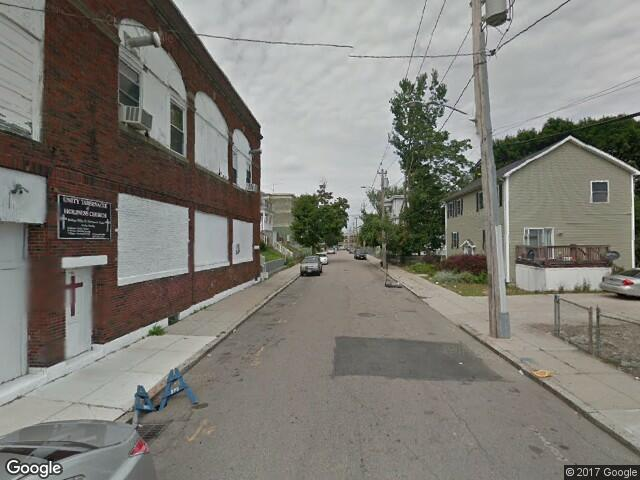

In [305]:
Image(retreivedDf[retreivedDf.keys()[k]]['origPath'])

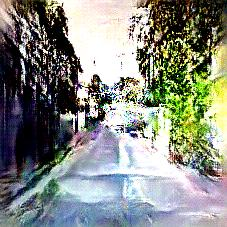

In [306]:
Image(retreivedDf[retreivedDf.keys()[k]]['XformPath'])

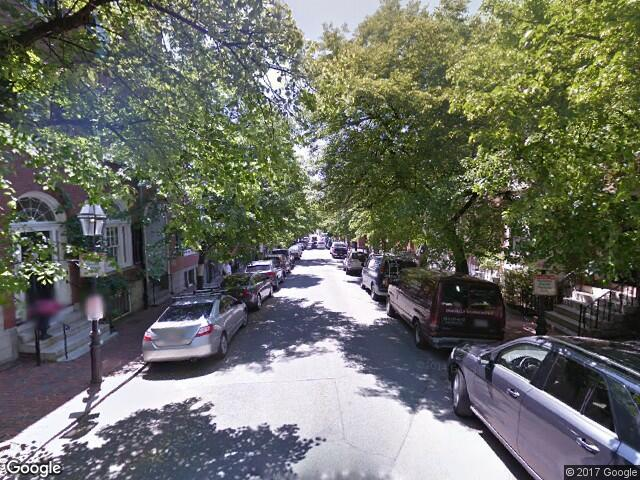

In [316]:
Image(retreivedDf[retreivedDf.keys()[k]]['Top5Paths'][0][4])

In [210]:
retreivedDf[retreivedDf.keys()[1]]

{'Top5Keys': [['51409002fdc9f049260001e3',
   '51421b09fdc9f049260083ec',
   '513d7cb7fdc9f03587006faa',
   '50f561bcfdc9f065f0005640',
   '50f60c41beb2fed910000174']],
 'Top5Locs': {'50f561bcfdc9f065f0005640': {'lat': 1.356857,
   'long': 103.77132600000004},
  '50f60c41beb2fed910000174': {'lat': 45.593907, 'long': -122.650531},
  '513d7cb7fdc9f03587006faa': {'lat': 33.809155, 'long': -84.46529299999997},
  '51409002fdc9f049260001e3': {'lat': 38.740961, 'long': -9.173535000000015},
  '51421b09fdc9f049260083ec': {'lat': 48.083479, 'long': 11.671914000000017}},
 'Top5Paths': [['/work/sagarj/Work/BellLabs/streetview/PPImages/51409002fdc9f049260001e3.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/51421b09fdc9f049260083ec.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/513d7cb7fdc9f03587006faa.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f561bcfdc9f065f0005640.jpg',
   '/work/sagarj/Work/BellLabs/streetview/PPImages/50f60c41beb2fed910000174.jpg']],
 'XformP

In [ ]:
# from shutil import copyfile
# import csv

In [ ]:
#Sample images for mturk experiment

# mturkDir = "/work/sagarj/Work/work_ipython/BellLabs/Data/Mturk/"
# urlPrepend = "https://nms.kcl.ac.uk/netsys/data/urbanBeautyCrowd/Mturk/"
# original = "Grp1/"
# Xformed = "Grp2/"
# batchSize = 200
# start = 0
# saveDict = {}
# turk = open(mturkDir + "csvMturk.csv" , 'wb')
# csvWriter = csv.writer(turk, delimiter=',')
# csvWriter.writerow(['image_A_url' ,'image_B_url'])
# for k in retreivedDf:
#     label = retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1]
#     saveDict[k] = label
#     srcFile = k+'_o.jpg'
#     destFile = k+'_x.jpg'
#     copyfile(retreivedDf[k]['origPath'] , mturkDir + original + srcFile)
#     copyfile(retreivedDf[k]['Top5Paths'][0][0] , mturkDir + Xformed + destFile)
#     csvWriter.writerow([urlPrepend + original + srcFile , urlPrepend + Xformed + destFile])
#     start+=1
#     if start >= batchSize:
#         break
# turk.close()

# with open("../Data/mturkPilotLabels.pkl",'wb') as f:
#     pickle.dump(saveDict , f , protocol=pickle.HIGHEST_PROTOCOL)
    
    
    
    



In [ ]:
with open("../Data/mturkPilotLabels.pkl",'rb') as f:
    saveDict = pickle.load(f)

In [ ]:
# with open("../Data/retreivedfringeDataframe2.pkl" , 'wb') as f:
#     pickle.dump(retreivedDf , f , protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
mturkResults = "../Data/mturk_pilot2.csv"
results = pd.read_csv(mturkResults)


In [ ]:
results.head()

In [ ]:
grouped = results.groupby('HITId')
votes = {}
for k in grouped.groups.keys():
    votes[k] = grouped.get_group(k)

In [ ]:
#results.head()

### calculate agreement with humans regarding agreement

In [ ]:
beautyAgree = 0
beautyDisagree = 0
uglyAgree = 0
uglyDisagree = 0
totalb = 0
totalu = 0
#confuse = 0
for k in votes:
    a  = sum(votes[k]['Answer.choice'] == 'optionB')
    key = votes[k]['Input.image_A_url'].iloc[0].split('/')[-1].split('_')[0]
    if key in saveDict:
        if saveDict[key]=='1':
            totalb+=1
            if a >= 2: 
                beautyAgree+=1
            else:
                beautyDisagree+=1
        else:
            totalu+=1
            if a < 2:
                uglyAgree+=1
            else:
                uglyDisagree+=1
                
            
        

In [ ]:
print float((beautyAgree + uglyAgree))/200 , float(beautyAgree)/totalb , float(uglyAgree)/totalu

# After this step, run the segnet code to extract the right labeled pixel info

In [ ]:
len(segnetLabels.keys()) , len(testSegnetLabels.keys())

In [ ]:
collections.Counter(np.squeeze(testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels']).flatten())

In [ ]:
segnetLabels[segnetLabels.keys()[10]]['segnetLabels'].shape

In [ ]:
testSegnetLabels[testSegnetLabels.keys()[10]]['segnetLabels'].shape

In [ ]:
retreivedDf[retreivedDf.keys()[101]]['Top5Keys'][0]

# This section is for calculating normalized ratios of the segnet labels

In [ ]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']
def shannonEntropy(segnetNormedDict):
    shannonVec = []
    for i in range(len(labels)):
        if i in segnetNormedDict:
            shannonVec.append(segnetNormedDict[i])
    return -np.sum([pA*np.log(pA) for pA in shannonVec])



In [ ]:
def normalizeDict(d, denom):
    normDict = {}
    for k in d : 
        normDict[k] = float(d[k])/float(denom)
    return normDict

deltas = {}
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    deltas[retreivedDf[k]['key']] = {}
    deltas[retreivedDf[k]['key']]['act'] = xformact
    deltas[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    
    labels = np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'])
    denom = labels.shape[0]*labels.shape[1]
    if retreivedDf[k]['key'] in segnetLabels.keys():
        origLabels = normalizeDict(collections.Counter(np.squeeze(segnetLabels[retreivedDf[k]['key']]['segnetLabels'].flatten())) , denom)
        deltas[retreivedDf[k]['key']]['origLabels'] = {}
        deltas[retreivedDf[k]['key']]['origLabels'] = origLabels
        deltas[retreivedDf[k]['key']]['entropy'] = shannonEntropy(origLabels)
        deltas[retreivedDf[k]['key']]['top5'] = []
        deltas[retreivedDf[k]['key']]['top5Entropy']  = []
        matchList = retreivedDf[k]['Top5Keys'][0]
        for l in matchList:
            if l in testSegnetLabels.keys():
                top5segnet = normalizeDict(collections.Counter(np.squeeze(testSegnetLabels[l]['segnetLabels'].flatten())) , denom)
                deltas[retreivedDf[k]['key']]['top5'].append(top5segnet)
                deltas[retreivedDf[k]['key']]['top5Entropy'].append(shannonEntropy(top5segnet))
                
    
    
    
    
    

In [ ]:
deltas[deltas.keys()[0]]

In [ ]:
# with open("SegnetDictionary.pkl" , 'wb') as f:
#     pickle.dump(deltas , f , protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# deltas[deltas.keys()[100]]['top5']
mean = {}
std = {}

scores = {}
beautfiedScores = {}
uglifiedScores = {}
beautifiedEntropy = []
uglifiedEntropy = []
origScores = {}
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            if dim not in scores:
                
                origScores[dim] = []
                beautfiedScores[dim] = []
                uglifiedScores[dim] = []
                scores[dim] = []
            
            scores[dim].append(ratios[dim])
            #Find change in scores and the score 
            orig_score = 0.0
            if dim in deltas[k]['origLabels']:
                orig_score = deltas[k]['origLabels'][dim]
            origScores[dim].append(orig_score)
            if deltas[k]['label'] == 1:
                beautfiedScores[dim].append(ratios[dim] - orig_score)                
            else:
                uglifiedScores[dim].append(ratios[dim] - orig_score)
               
        if deltas[k]['label'] == 1:
            beautifiedEntropy =  beautifiedEntropy + deltas[k]['top5Entropy']
        else:
            uglifiedEntropy = uglifiedEntropy + deltas[k]['top5Entropy']
#print scores.keys()
for k in origScores:
    mean[k] = np.mean(origScores[k])
    std[k] = np.std(origScores[k])
    
print mean , std

In [ ]:
#calculate change in object value in terms of Zscore in original population


beautfiedZscores = {}
uglifiedZscores = {}
for k in beautfiedScores:
    if k not in beautfiedZscores:
        beautfiedZscores[k] = []
        
    for val in beautfiedScores[k]:
        orig = beautfiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        beautfiedZscores[k].append(Zscore)


for k in uglifiedScores:
    if k not in uglifiedZscores:
        uglifiedZscores[k] = []
        
    for val in uglifiedScores[k]:
        orig = uglifiedScores[dim]
        Zscore = (orig - mean[dim])/std[dim]
        uglifiedZscores[k].append(Zscore)

In [ ]:
#beautfiedScores[1]

### Plot deltas between original and transformed (measurement)

In [ ]:
dim = 6

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautfiedScores[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Change in Ratio: Beautified Images"})
sns.distplot(uglifiedScores[dim] , kde_kws={"color": "g", "lw": 2, "label": "Change in Ratio: Uglified Images"})
ax.axvline(x=np.median(beautfiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglifiedScores[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Change in ratio for Greenery in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [ ]:
np.mean(beautfiedScores[dim]),np.mean(uglifiedScores[dim])

In [ ]:
len(uglifiedEntropy), len(beautifiedEntropy)

In [ ]:
# uglifiedEntropy

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(np.asarray(beautifiedEntropy) ,kde_kws={"color": "b", "lw": 2, "label": "Visual Entropy of beautified images"})
sns.distplot(np.asarray(uglifiedEntropy) , kde_kws={"color": "g", "lw": 2, "label": "Visual Entropy uglified images"})
ax.axvline(x=np.median(beautifiedEntropy), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglifiedEntropy), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
# plt.xlabel("Change in ratio for  " + segnetLabels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [ ]:
beautyStatus = []
vectors = []
dims = [0.0 , 1.0 ]
sky = []
entropy = []

#Set this var for the binned plot analuysos, 0 for sky , 1 for building , 6 for trees
BinnedPlotDim = 0.0 
for k in deltas:
    for top5ratios in deltas[k]['top5']:
        i = 0
        
        #This part is to extract dependent ratios and individual rations between different segnet dimensions
        #the compount vector helps quantifyng dependatbility of Dims mentioned in dims vector
        vec = []
        for j in dims:
            compound = 1.0
            if j in top5ratios:
                if j in deltas[k]['origLabels']:
                    vec.append(top5ratios[j]-deltas[k]['origLabels'][j])
                else:
                    vec.append(top5ratios[j])
                
            else:
                vec.append(0.0)
        for val in vec:
            compound = compound * val
        vec.append(compound)
        
        
        #This part is actually looking at change in dimentions for the binned plot analysis 
        if BinnedPlotDim in top5ratios:
            if BinnedPlotDim in deltas[k]['origLabels']:
                sky.append(top5ratios[BinnedPlotDim])#-deltas[k]['origLabels'][BinnedPlotDim])
            else:
                sky.append(top5ratios[BinnedPlotDim])
            #sky.append(ratios[0.0]/ratios[6.0])
        else:
            sky.append(0.0)
        entropy.append(deltas[k]['top5Entropy'][i])
        i+=1
        beautyStatus.append(deltas[k]['label'])
        vectors.append(vec)
        

In [ ]:
len(sky) , len(entropy) , len(beautyStatus)

In [ ]:

sns.distplot(entropy)

# All the code after this is for measurement and explainability aspect of the deep network

# Binned Plot 

In [ ]:
bins = {}
compexityBin = {}
for i in range(6):
    bins[i] = {}
    compexityBin[i] ={}
    bins[i]['label'] = []
    compexityBin[i]['label'] = []
    bins[i]['beauty'] = []
    compexityBin[i]['beauty'] = []
    bins[i]['ugly'] = []
    compexityBin[i]['ugly'] = []

#this bit is for finding sky trends in an absolute sense.

for k in range(len(sky)):
    if sky[k] <= 0.07 :
        bins[0]['label'].append(beautyStatus[k])
    elif sky[k] > 0.07 and sky[k] <= 0.14:
        bins[1]['label'].append(beautyStatus[k])
    elif sky[k] >0.14 and sky[k] <= 0.21:
        bins[2]['label'].append(beautyStatus[k])
    elif sky[k] >  0.21 and sky[k] <= 0.28:
        bins[3]['label'].append(beautyStatus[k])
    elif sky[k] > 0.28 and sky[k] <= 0.35 :
        bins[4]['label'].append(beautyStatus[k])
    elif sky[k] > 0.35 :
        bins[5]['label'].append(beautyStatus[k])

        
#Entropy Bins: 
for k in range(len(entropy)):
    if entropy[k] > 0.5 and entropy[k] <= 0.75:
        compexityBin[0]['label'].append(beautyStatus[k])
    elif entropy[k] > 0.75 and entropy[k] <= 1.0:
        compexityBin[1]['label'].append(beautyStatus[k])
    elif entropy[k] >1.0 and entropy[k] <= 1.25 :
        compexityBin[2]['label'].append(beautyStatus[k])
    elif entropy[k] >  1.25 and entropy[k] <= 1.5:
        compexityBin[3]['label'].append(beautyStatus[k])
    elif entropy[k] > 1.5 and entropy[k] <= 1.75 :
        compexityBin[4]['label'].append(beautyStatus[k])
    elif entropy[k] > 1.75 and entropy[k] <= 2.0 :
        compexityBin[5]['label'].append(beautyStatus[k])

#This bit is to find binned plot for Sky Delta

# for k in range(len(sky)):
#     if sky[k] <= -0.3 :
#         bins[0]['label'].append(beautyStatus[k])
#     elif sky[k] > -0.3 and sky[k] <= -0.1:
#         bins[1]['label'].append(beautyStatus[k])
#     elif sky[k] >-0.1 and sky[k] <= 0.1:
#         bins[2]['label'].append(beautyStatus[k])
#     elif sky[k] > 0.1 and sky[k] <= 0.3:
#         bins[3]['label'].append(beautyStatus[k])
# #     elif sky[k] > 0.3 and sky[k] <= 0.5 :
# #         bins[4]['label'].append(beautyStatus[k])
#     elif sky[k] > 0.3 :
#         bins[4]['label'].append(beautyStatus[k])
    


In [ ]:
iters = 100 
sampleSize = 100
for i in range(iters):
    for k in bins:
        sample = random.sample(bins[k]['label'] , sampleSize)
        bins[k]['beauty'].append(sum(sample))
#         bins[k]['beauty'].append(sum(bins[k]['label']))
        bins[k]['ugly'].append(len(sample) - sum(sample))

In [ ]:
iters = 100 
sampleSize = 100
for i in range(iters):
    for k in compexityBin:
        sample = random.sample(compexityBin[k]['label'] , sampleSize)
        compexityBin[k]['beauty'].append(sum(sample))
#         bins[k]['beauty'].append(sum(bins[k]['label']))
        compexityBin[k]['ugly'].append(len(sample) - sum(sample))

(array([   0.,   20.,   40.,   60.,   80.,  100.]),
 <a list of 6 Text yticklabel objects>)

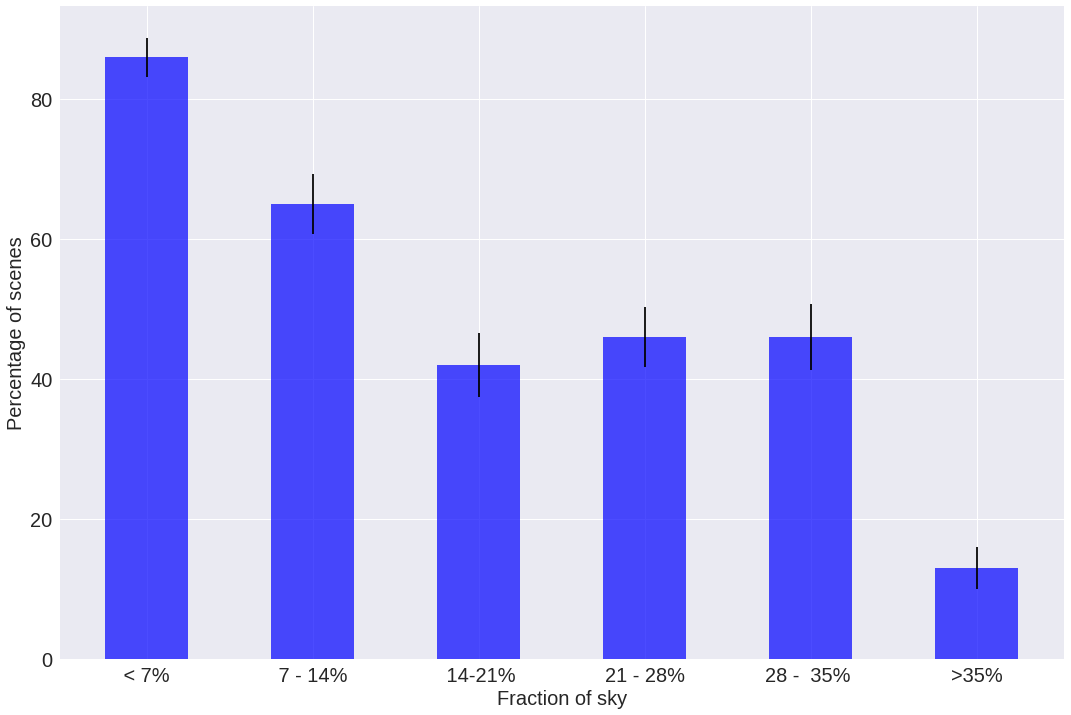

In [244]:
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
errorBeauty = [np.std(bins[i]['beauty']) for i in bins]

#ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['beauty']) for i in bins], yerr=errorBeauty, fmt='-o')

rects1 = ax.bar(np.arange(0,len(bins), 1), [np.median(bins[i]['beauty']) for i in bins], 0.5, color='b', yerr=errorBeauty ,alpha=0.7)

# plt.plot([np.median(bins[i]['ugly']) for i in bins])
# errorUgly = [np.std(bins[i]['ugly']) for i in bins]
# ax.errorbar(np.arange(0,len(bins), 1), [np.median(bins[i]['ugly']) for i in bins], yerr=errorUgly, fmt='-o')
plt.xlabel("Fraction of sky" , fontsize = 20)
plt.ylabel("Percentage of scenes" , fontsize = 20 )

#ticks = [' Less Sky ' , ' ' , '' , '', ' More Sky ' ]
# ticks = [' Reduce by > 30% ' , ' Reduce by 10 - 30% ' , ' No change ' , 'Increase by 10 - 30%', ' Increase by > 30% ' ]
ticks = [' < 7% ' , ' 7 - 14% ' , ' 14-21%' , '21 - 28%', '28 -  35% ' , '>35%' ]
plt.xticks(range(len(bins)) , ticks , fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(['Beautiful Images','Ugly Images'])

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 7 Text yticklabel objects>)

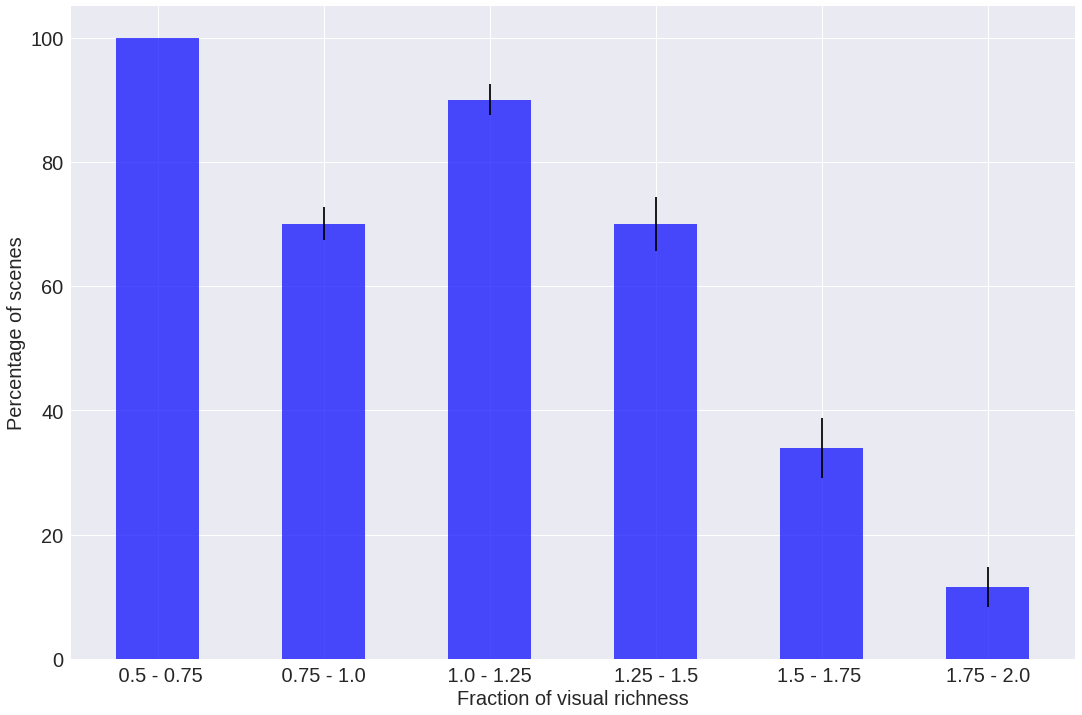

In [245]:
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
errorBeauty = [np.std(compexityBin[i]['beauty']) for i in compexityBin]
# ax.errorbar(np.arange(0,len(compexityBin), 1), [np.median(compexityBin[i]['beauty']) for i in compexityBin], yerr=errorBeauty, fmt='-o')
rects1 = ax.bar(np.arange(0,len(compexityBin), 1), [np.median(compexityBin[i]['beauty']) for i in compexityBin], 0.5, color='b', yerr=errorBeauty ,alpha=0.7)


# errorUgly = [np.std(compexityBin[i]['ugly']) for i in compexityBin]
# ax.errorbar(np.arange(0,len(compexityBin), 1), [np.median(compexityBin[i]['ugly']) for i in compexityBin], yerr=errorUgly, fmt='-o')

plt.xlabel("Fraction of visual richness" , fontsize = 20)
plt.ylabel("Percentage of scenes" , fontsize = 20 )

ticks = [' 0.5 - 0.75' , ' 0.75 - 1.0 ' , ' 1.0 - 1.25 ' , '1.25 - 1.5', '1.5 - 1.75 ' , '1.75 - 2.0' ]
plt.xticks(range(len(compexityBin)) , ticks , fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(['Beautiful Images','Ugly Images'])

(array([  0.,  20.,  40.,  60.,  80.]), <a list of 5 Text yticklabel objects>)

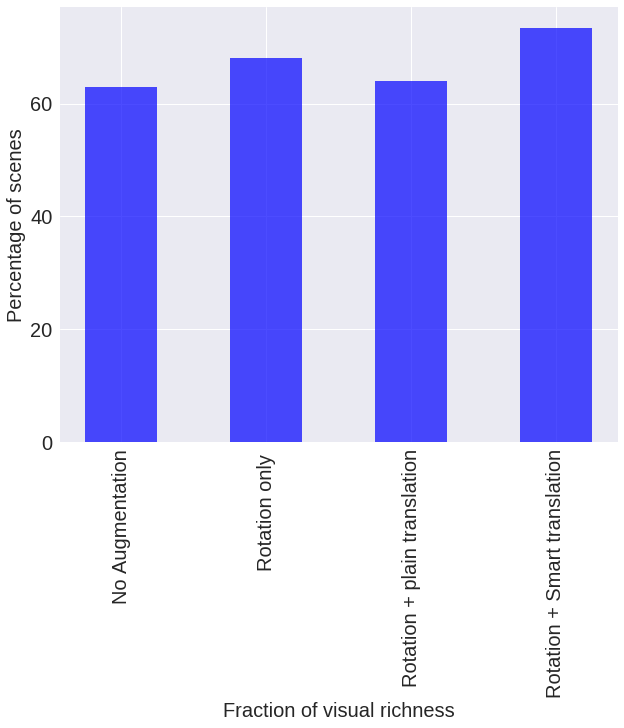

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
rects1 = ax.bar(np.arange(0, 4, 1), [63.0 , 68.0 , 64.0 , 73.5], 0.5, color='b' ,alpha=0.7)

plt.xlabel("Fraction of visual richness" , fontsize = 20)
plt.ylabel("Classifier Accuracy" , fontsize = 20 )

ticks = ['No Augmentation' , 'Rotation only ' , 'Rotation + plain translation' , 'Rotation + Smart translation']
plt.xticks(range(len(np.arange(0, 4, 1))) , ticks , fontsize=20 , rotation=90)
plt.yticks(fontsize=20)
# plt.legend(['Beautiful Images','Ugly Images'])


In [170]:
vectors[:10]

[[-0.16833912037037035, -0.025902777777777778, 0.004360450826260288],
 [-0.15958333333333333, -0.004508101851851853, 0.0007194179205246916],
 [-0.02708333333333332, -0.024467592592592593, 0.0006626639660493824],
 [-0.04059027777777777, -0.02516203703703704, 0.0010213340727880655],
 [-0.04872685185185183, -0.0003703703703703716, 1.8046982167352588e-05],
 [-0.2191435185185185, -0.09727430555555555, 0.021317033580889915],
 [-0.03554398148148147, -0.06222222222222221, 0.002211625514403291],
 [-0.10942129629629627, -0.11482060185185185, 0.012563819096150544],
 [-0.15351273148148145, -0.09410300925925924, 0.014446009992016026],
 [-0.20126157407407405, 0.018819444444444444, -0.003787631012088477]]

In [ ]:
X = 100*np.asarray(vectors)
X.shape

In [ ]:
X[:10]

In [ ]:
len(labels), len(vectors)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import r2_score , precision_score
# clf = LogisticRegression(fit_intercept=True, n_jobs=1)
# model = clf.fit(X, labels)
# #model.score()

# clf.predict(X)

# model.coef_

# predicted = model.predict(X)

# 1 - model.score(X , labels)

# from sklearn.model_selection import cross_val_score
# cross_val_score(model , X , labels , scoring='r2' )

# precision_score(predicted,labels)

# r2_score(predicted , labels)

In [ ]:
# import seaborn as sns
# fig, ax = plt.subplots()
# fig.set_size_inches(14, 8)
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (20, 14)})
# sns.set(font_scale=1.5) 
# ax = sns.barplot(x=labels, y=np.concatenate((plotablesUgly,plotablesBeauty) , axis = 0))
# ax.set(xlabel='Segnet Objects inpainted', ylabel='Percentage Reduction (Recalls in Classifier\'s Beauty prediction')

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(beautfiedScores[dim] , uglifiedScores[dim])

In [ ]:

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [ ]:
cohen_d(beautfiedScores[dim] , uglifiedScores[dim])

In [ ]:
mean

In [ ]:
# Find update Z scores in deltas:
for k in deltas:
    for ratios in deltas[k]['top5']:
        for dim in ratios:
            orig = ratios[dim]
            Zscore = (orig - mean[dim])/std[dim]
            ratios[dim] = Zscore

In [ ]:
deltas[deltas.keys()[1]]

In [ ]:
## Get label wise dimensions for uglified and beautified images (top 1 image)

acts = []
action = []
labelDeltas = [[] for i in range(len(labels))]

for k in deltas:
    #if deltas[k]['act'] > 0.1:
    #for c in deltas[k]['top5']:
    if len(deltas[k]['top5']) > 0:
        c = deltas[k]['top5'][0]
        action.append(deltas[k]['label'])
        acts.append(deltas[k]['act'])
        for dims in range(len(labels)):
            delta = 0.0
            if dims in c:
                delta = c[dims]
            labelDeltas[int(dims)].append(delta)

In [ ]:
labelDeltas[0]

In [ ]:
labels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [ ]:
dim = 9

1000 1000 1000


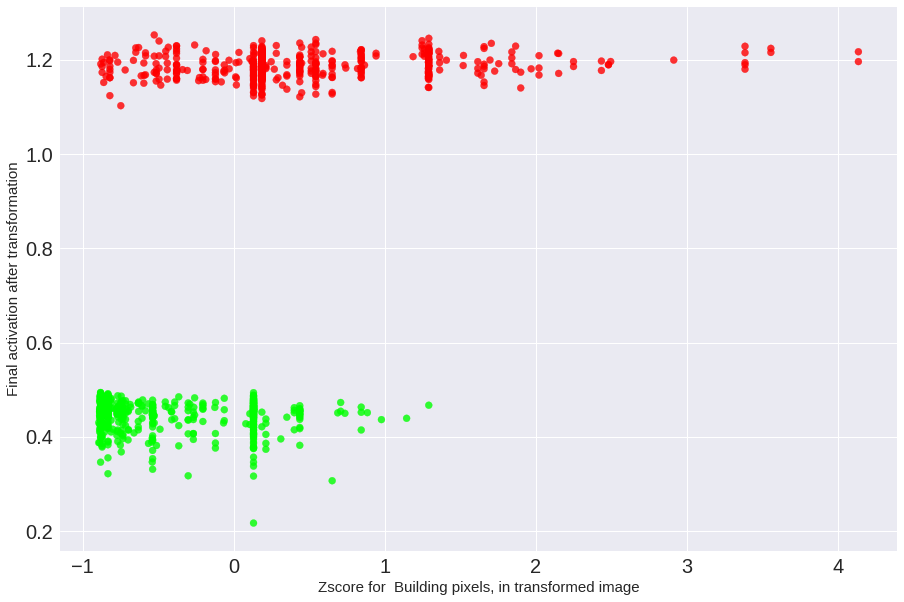

In [171]:
#beautiFied = [labelDeltas[5][i] for i in range
colorPallet=["#FF0000", "#00FF00"]

colors = [colorPallet[action[i]] for i in range(len(action)) if labelDeltas[dim][i] != 0.0 ]
delRatio = [labelDeltas[dim][i] for i in range(len(labelDeltas[dim])) if labelDeltas[dim][i] != 0.0]
delActs = [acts[i] for i in range(len(acts)) if labelDeltas[dim][i] != 0.0 ]
print len(delRatio) , len(delActs) , len(colors)
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 15)
plt.ylabel("Final activation after transformation" , fontsize = 15 )
fig = plt.scatter( delRatio , delActs,  alpha=0.8 , c = colors)
#plt.legend(['Uglified' , 'Beautified'])
plt.show()

In [ ]:
len(labelDeltas[0])

Extract Beauty and ugly scores for each image based on action (uglified or beautified

In [ ]:
beautyDim = []


for j in range(len(labels)):
    beautyDim.append([labelDeltas[j][i] for i in range(len(action)) if (action[i]==1 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==1 ])

In [ ]:
uglyDim = []

for j in range(len(labels)):
    uglyDim.append([labelDeltas[j][i] for i in range(len(action)) if(action[i]==0 and labelDeltas[j][i] != 0.0)])
    #Acts.append([acts[i] for i in range(len(action)) if action[i]==0 ])

In [ ]:
print len(beautyDim[11])

In [ ]:
print labels

In [ ]:
dim = 1

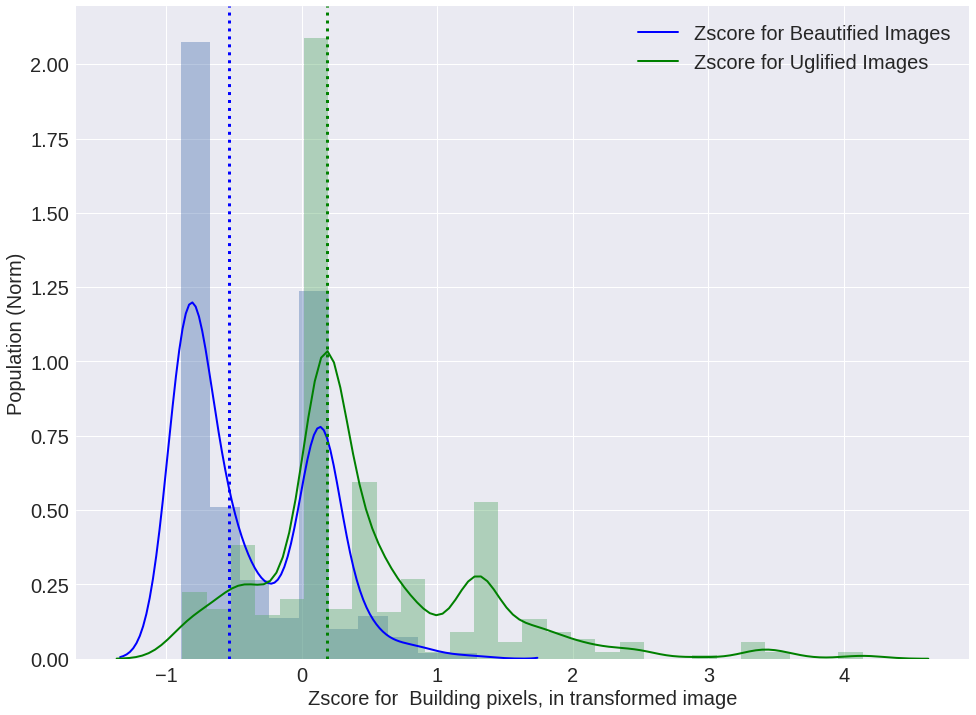

In [172]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyDim[dim] ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyDim[dim] , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyDim[dim]), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for  " + labels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Population (Norm)" , fontsize = 20 )

In [ ]:
retreivedDf[retreivedDf.keys()[1]]

In [ ]:
# beautifiedPlaces = []
# #beautyOrig = []
# uglifiedPlaces = []
# #uglyOrig = []c

# c1 = 0
# c2 = 0
# for k in retreivedDf:
#     if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '0':
#         #uglyOrig.append(getPlaces(retreivedDf[k]['origPath'])
#         c1+=1
# #         if c1 >= 61:
# #             continue
#         uglifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#     else:
#         #beautyOrig.append(getPlaces(retreivedDf[k]['origPath']))
#         beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))
#         c2+=1

In [ ]:
# Find difference of scenes between original and transformed

beautifiedPlaces = []
uglifiedPlaces = []
for k in retreivedDf:
    if retreivedDf[k]['XformPath'].split('/')[-1].split('_')[1][-1] == '1':     
        uglifiedPlaces.append(getPlaces(retreivedDf[k]['origPath']))
        beautifiedPlaces.append(getPlaces(retreivedDf[k]['Top5Paths'][0][0]))

In [177]:
with open("beautifiedRetrieval_all.pkl",'wb') as f:
    pickle.dump(beautifiedPlaces,f)
    
with open("uglifiedRetrieval_all.pkl",'wb') as f:
    pickle.dump(uglifiedPlaces,f)

In [178]:
# print "Done" , str(c1) , str(c2)

In [179]:
with open("../Data/categoryIndex_places205.csv" , 'rb') as f:
    cats = f.readlines()

In [180]:
cats[1]

'/a/airport_terminal 1,,U,L\r\n'

In [181]:
catDict = {}
for c in cats:
    comps = c.strip().split(',')
    idx = comps[0].split(' ')[1]
    lbl = comps[0].split(' ')[0]
    catDict[idx] = {}
    catDict[idx]['label'] = lbl
    catDict[idx]['tnomy'] = comps[-1]


In [182]:
catDict

{'0': {'label': '/a/abbey', 'tnomy': 'W'},
 '1': {'label': '/a/airport_terminal', 'tnomy': 'L'},
 '10': {'label': '/a/assembly_line', 'tnomy': ''},
 '100': {'label': '/i/iceberg', 'tnomy': ''},
 '101': {'label': '/i/igloo', 'tnomy': ''},
 '102': {'label': '/i/islet', 'tnomy': ''},
 '103': {'label': '/i/ice_skating_rink/outdoor', 'tnomy': 'L'},
 '104': {'label': '/i/inn/outdoor', 'tnomy': 'A'},
 '105': {'label': '/j/jail_cell', 'tnomy': ''},
 '106': {'label': '/k/kasbah', 'tnomy': ''},
 '107': {'label': '/k/kindergarden_classroom', 'tnomy': ''},
 '108': {'label': '/k/kitchen', 'tnomy': ''},
 '109': {'label': '/k/kitchenette', 'tnomy': ''},
 '11': {'label': '/a/attic', 'tnomy': ''},
 '110': {'label': '/l/laundromat', 'tnomy': ''},
 '111': {'label': '/l/lighthouse', 'tnomy': 'L'},
 '112': {'label': '/l/living_room', 'tnomy': ''},
 '113': {'label': '/l/lobby', 'tnomy': ''},
 '114': {'label': '/l/locker_room', 'tnomy': ''},
 '115': {'label': '/m/mansion', 'tnomy': 'L'},
 '116': {'label': '/

In [183]:
def getTnomyCount(placesProbs,lblDict):
    mapper = {'W':'Walkable' , 'L' : 'Landmark' , 'A' : 'Architectural' , 'N' : 'Natural' }
    TnomyCount = {'Walkable' : 0 , 'Landmark': 0 , 'Architectural' : 0 , 'Natural' : 0}
    TnomyLabels = {'Walkable' : [] , 'Landmark': [] , 'Architectural' : [] , 'Natural' : []}
    labelList = []
    for arr in placesProbs:
        probs = np.squeeze(arr)
        topArgs = probs.argsort()[-5:][::-1]
       
        for i in topArgs:
            key = str(i)
            if lblDict[key]['tnomy'] != '':
                tnomy = lblDict[key]['tnomy']
                TnomyCount[mapper[tnomy]]+=1
                labelList.append(lblDict[key]['label'])
                TnomyLabels[mapper[tnomy]].append(lblDict[key]['label'])
    return TnomyCount , labelList , TnomyLabels

In [184]:
beautfiedTnomy, beautifiedLabels , beautyTnomyLabels = getTnomyCount(beautifiedPlaces,catDict)

In [185]:
#beauOrigTnomy , beauOrigLabels = getTnomyCount(beautyOrig,catDict)

In [186]:
#beautfiedTnomy,beauOrigTnomy

In [187]:
uglifiedTnomy, uglyfiedLabels, uglyTnomyLabels = getTnomyCount(uglifiedPlaces,catDict)

In [188]:
print beautfiedTnomy , uglifiedTnomy

{'Landmark': 205, 'Walkable': 983, 'Natural': 247, 'Architectural': 885} {'Landmark': 304, 'Walkable': 450, 'Natural': 77, 'Architectural': 1417}


In [189]:
labels = [k for k in beautfiedTnomy]

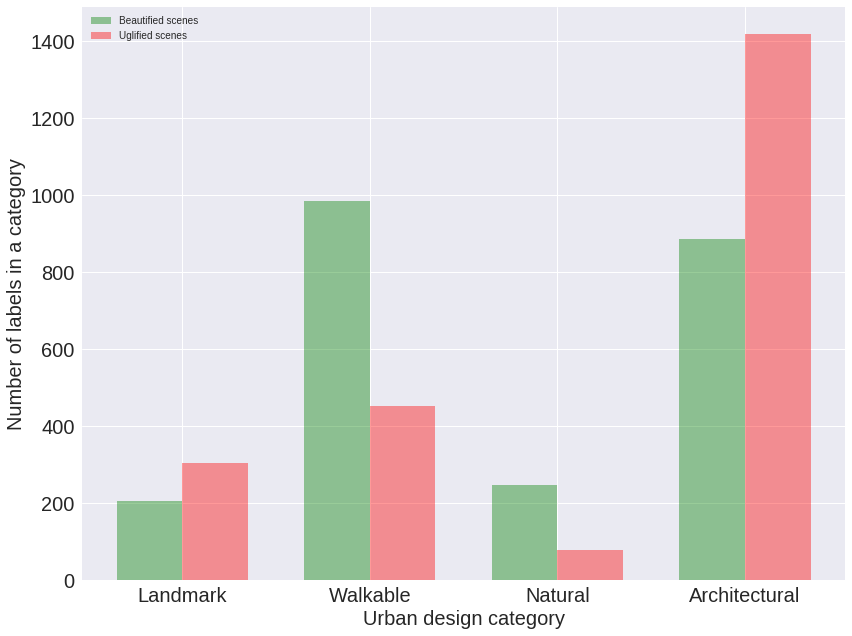

In [224]:
import seaborn as sns
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
bar_width = 0.35
index = np.arange(4)
opacity = 0.4
sns.set(font_scale=1) 
rects1 = plt.bar(index, [beautfiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Beautified scenes')
rects2 = plt.bar(index+bar_width, [uglifiedTnomy[l] for l in labels], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Uglified scenes')

plt.xlabel('Urban design category' , fontsize=20)
plt.ylabel('Number of labels in a category',fontsize=20)
#plt.title('Taxonomical analysis of Scene types',fontsize=20 )
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()


In [191]:
beautyTnomyLabels.keys()

['Landmark', 'Walkable', 'Natural', 'Architectural']

In [225]:
dim = 1
beautyTnomyCount = collections.Counter(beautyTnomyLabels[labels[dim]])
uglyTnomyCount = collections.Counter(uglyTnomyLabels[labels[dim]])
prevalenceDict = {}
for k in beautyTnomyCount:
    prevalenceDict[k] = beautyTnomyCount[k] - uglyTnomyCount[k]
    
sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

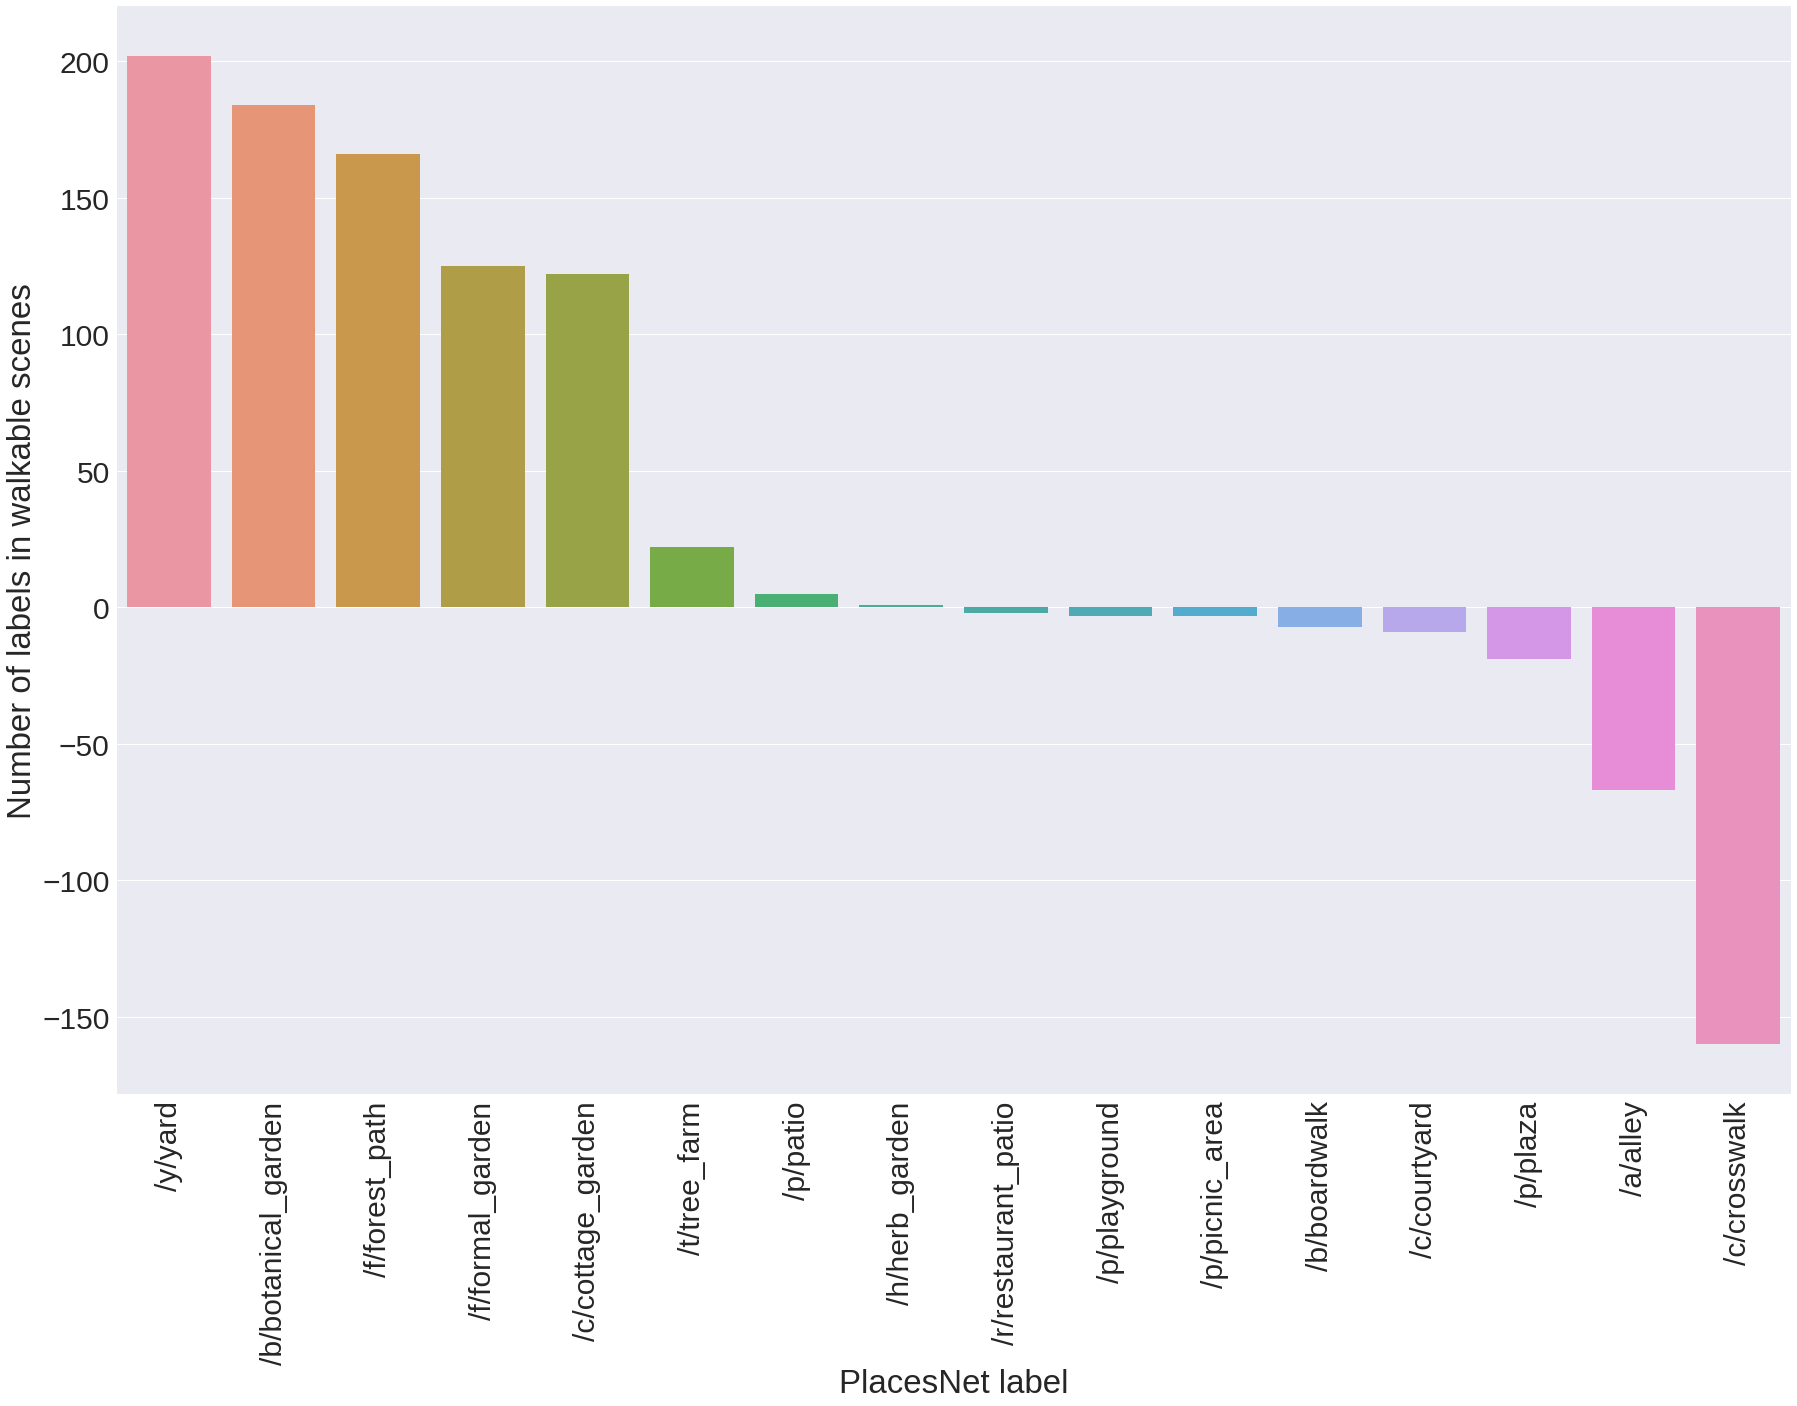

In [229]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=3) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='PlacesNet label', ylabel='Number of labels in walkable scenes') 

In [195]:
#uglyOrigTnomy , uglyOrigLabels = getTnomyCount(uglyOrig,catDict)

In [196]:
#uglifiedTnomy, uglyOrigTnomy

In [197]:
#uglyLabels

In [198]:
#beautifiedLabels

In [199]:
common = list(set(uglyfiedLabels).intersection(set(beautifiedLabels)))
#common = list(set(uglyOrigLabels).intersection(set(beauOrigLabels)))

In [200]:
beautySpecific = [i for i in beautifiedLabels if i not in common]
#beautySpecific = [i for i in beauOrigLabels if i not in common]

In [201]:
set(beautySpecific)

{'/c/cottage_garden', '/c/creek', '/p/pond'}

In [202]:
uglySpecific = [i for i in uglyfiedLabels if i not in common]

In [203]:
set(uglySpecific)

{'/a/airport_terminal',
 '/a/amphitheater',
 '/a/arch',
 '/b/bamboo_forest',
 '/b/baseball_field',
 '/b/building_facade',
 '/c/church/outdoor',
 '/c/corridor',
 '/c/courthouse',
 '/d/desert/sand',
 '/d/desert/vegetation',
 '/d/dock',
 '/d/doorway/outdoor',
 '/f/fairway',
 '/f/field/cultivated',
 '/f/field/wild',
 '/g/garbage_dump',
 '/g/golf_course',
 '/h/harbor',
 '/l/lighthouse',
 '/m/market/outdoor',
 '/m/mausoleum',
 '/m/medina',
 '/m/mountain',
 '/p/palace',
 '/p/pasture',
 '/p/pavilion',
 '/r/racecourse',
 '/r/restaurant',
 '/r/rice_paddy',
 '/r/ruin',
 '/r/runway',
 '/s/shopfront',
 '/s/ski_slope',
 '/s/sky',
 '/s/snowfield',
 '/s/stadium/baseball',
 '/s/stadium/football',
 '/s/subway_station/platform',
 '/s/supermarket',
 '/t/temple/south_asia',
 '/t/tower',
 '/v/valley',
 '/v/vegetable_garden',
 '/v/veranda',
 '/w/water_tower',
 '/w/wind_farm',
 '/w/windmill'}

In [204]:
#set(common)

In [205]:
beautyCount = collections.Counter(beautifiedLabels)
uglyCount = collections.Counter(uglyfiedLabels)
prevalenceDict = {}
for k in beautyCount:
    prevalenceDict[k] = beautyCount[k] - uglyCount[k]

In [206]:
beautyCount

Counter({'/a/alley': 32,
         '/a/amusement_park': 10,
         '/a/apartment_building/outdoor': 27,
         '/b/boardwalk': 15,
         '/b/botanical_garden': 190,
         '/b/bridge': 12,
         '/c/castle': 3,
         '/c/cemetery': 15,
         '/c/construction_site': 11,
         '/c/corn_field': 1,
         '/c/cottage_garden': 122,
         '/c/courtyard': 19,
         '/c/creek': 8,
         '/c/crosswalk': 3,
         '/d/dam': 4,
         '/d/driveway': 371,
         '/f/forest_path': 175,
         '/f/forest_road': 205,
         '/f/formal_garden': 126,
         '/f/fountain': 135,
         '/g/gas_station': 3,
         '/h/herb_garden': 3,
         '/h/highway': 58,
         '/h/hotel/outdoor': 6,
         '/i/inn/outdoor': 12,
         '/m/mansion': 9,
         '/m/motel': 10,
         '/o/office_building': 4,
         '/o/orchard': 60,
         '/p/parking_lot': 62,
         '/p/patio': 15,
         '/p/picnic_area': 2,
         '/p/playground': 5,
         '/p/

In [207]:
uglyCount

Counter({'/a/airport_terminal': 7,
         '/a/alley': 99,
         '/a/amphitheater': 3,
         '/a/amusement_park': 3,
         '/a/apartment_building/outdoor': 59,
         '/a/arch': 1,
         '/b/bamboo_forest': 1,
         '/b/baseball_field': 1,
         '/b/boardwalk': 22,
         '/b/botanical_garden': 6,
         '/b/bridge': 62,
         '/b/building_facade': 10,
         '/c/castle': 1,
         '/c/cemetery': 4,
         '/c/church/outdoor': 1,
         '/c/construction_site': 64,
         '/c/corn_field': 4,
         '/c/corridor': 2,
         '/c/courthouse': 1,
         '/c/courtyard': 28,
         '/c/crosswalk': 163,
         '/d/dam': 8,
         '/d/desert/sand': 3,
         '/d/desert/vegetation': 2,
         '/d/dock': 7,
         '/d/doorway/outdoor': 1,
         '/d/driveway': 122,
         '/f/fairway': 1,
         '/f/field/cultivated': 1,
         '/f/field/wild': 2,
         '/f/forest_path': 9,
         '/f/forest_road': 74,
         '/f/formal_garden

In [208]:

sortedPrevalence = sorted(prevalenceDict.items(), key=operator.itemgetter(1))[::-1]


In [209]:
sortedPrevalence

[('/d/driveway', 249),
 ('/y/yard', 202),
 ('/b/botanical_garden', 184),
 ('/f/forest_path', 166),
 ('/r/river', 146),
 ('/f/fountain', 133),
 ('/f/forest_road', 131),
 ('/f/formal_garden', 125),
 ('/c/cottage_garden', 122),
 ('/o/orchard', 43),
 ('/t/tree_farm', 22),
 ('/c/cemetery', 11),
 ('/s/swamp', 11),
 ('/r/rainforest', 9),
 ('/c/creek', 8),
 ('/a/amusement_park', 7),
 ('/m/mansion', 5),
 ('/p/pond', 5),
 ('/p/patio', 5),
 ('/c/castle', 2),
 ('/i/inn/outdoor', 1),
 ('/h/hotel/outdoor', 1),
 ('/h/herb_garden', 1),
 ('/s/swimming_pool/outdoor', -1),
 ('/s/ski_resort', -2),
 ('/t/temple/east_asia', -2),
 ('/r/restaurant_patio', -2),
 ('/p/playground', -3),
 ('/c/corn_field', -3),
 ('/p/picnic_area', -3),
 ('/d/dam', -4),
 ('/b/boardwalk', -7),
 ('/c/courtyard', -9),
 ('/s/skyscraper', -12),
 ('/g/gas_station', -13),
 ('/p/plaza', -19),
 ('/a/apartment_building/outdoor', -32),
 ('/b/bridge', -50),
 ('/c/construction_site', -53),
 ('/s/slum', -61),
 ('/a/alley', -67),
 ('/o/office_bu

In [210]:
Xlabel = [i[0] for i in sortedPrevalence]
YFreq = [i[1] for i in sortedPrevalence]

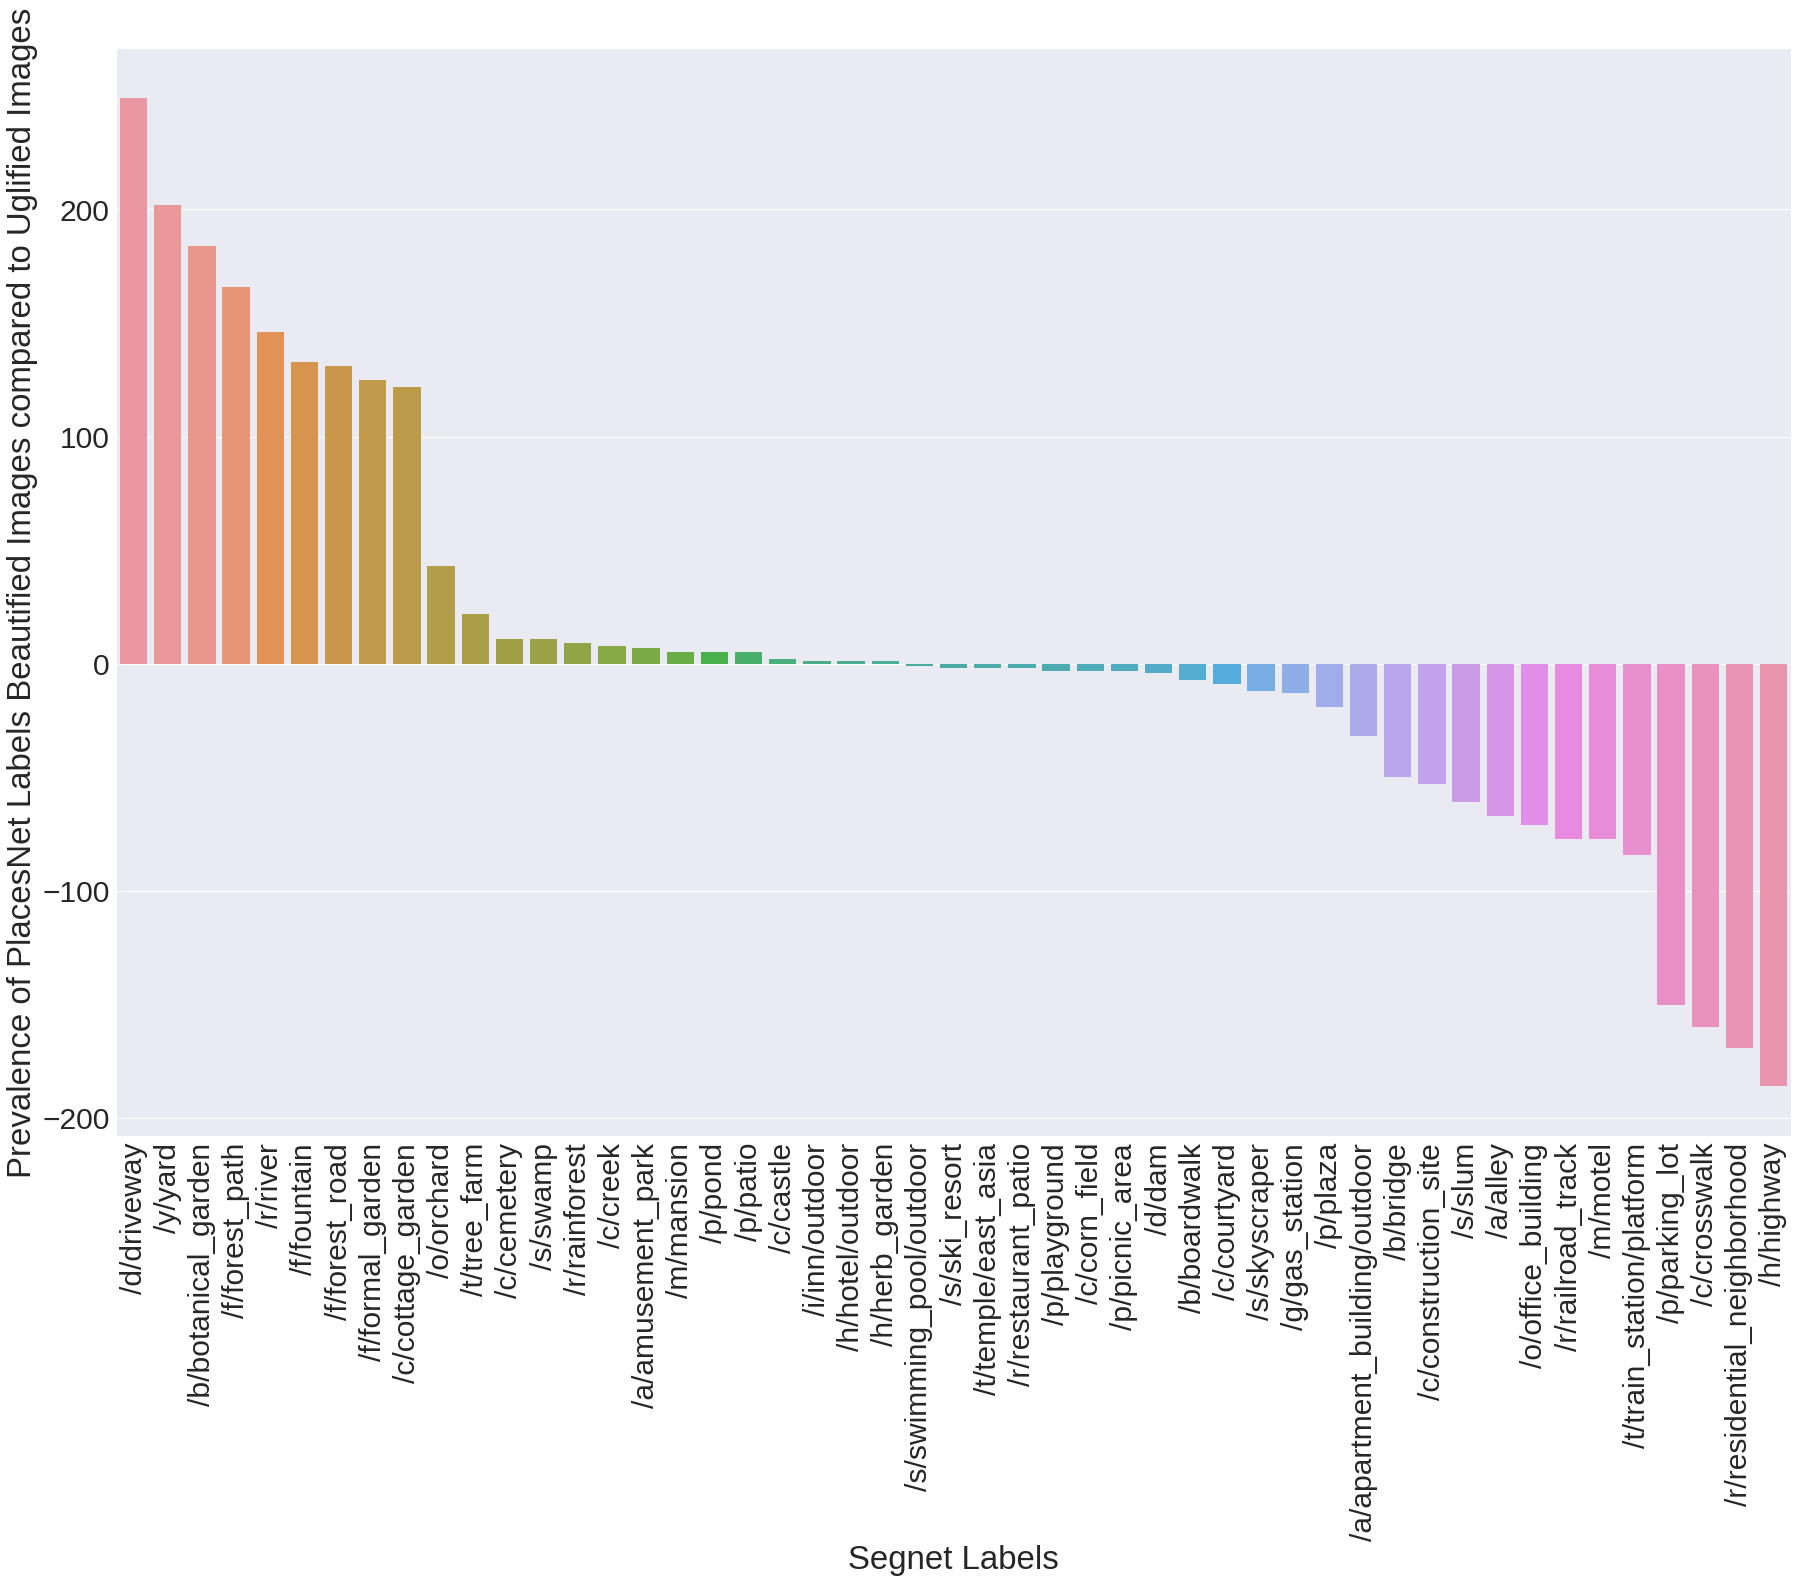

In [213]:
fig, ax = plt.subplots(figsize=(30,20))

sns.set_style("whitegrid")
#sns.set(rc={"figure.figsize": (20, 14)})
sns.set(font_scale=2) 
sns.barplot(ax = ax , x=Xlabel, y=YFreq )
plt.xticks(rotation=90)
ax.set(xlabel='Segnet Labels', ylabel='Prevalence of PlacesNet Labels Beautified Images compared to Uglified Images')

## Do some texture analysis

In [214]:
# retreivedDf[retreivedDf.keys()[1]]['Top5Keys'][0]

In [215]:
textureDf = {}
textureLabels = ['Building', 'Road', 'Sky', 'Tree' ]
for k in retreivedDf:
    xforminfo = retreivedDf[k]['XformPath'].split('/')[-1].split('_')
    xformLabel = xforminfo[1]
    xformact = float(xforminfo[2])
    
    textureDf[retreivedDf[k]['key']] = {}
    textureDf[retreivedDf[k]['key']]['act'] = xformact
    textureDf[retreivedDf[k]['key']]['label'] = int(xformLabel[-1])
    textureDf[retreivedDf[k]['key']]['textures'] = []
    for l in textureLabels:
        textureDf[retreivedDf[k]['key']]['textures'].append( np.median(segnetLabels[retreivedDf[k]['key']][l]))
    textureDf[retreivedDf[k]['key']]['Top5'] = {}
    matchList = retreivedDf[k]['Top5Keys'][0]
    for m in matchList:  
        if m in testSegnetLabels.keys():
            textureDf[retreivedDf[k]['key']]['Top5'][m] = []
            for l in textureLabels:
                textureDf[retreivedDf[k]['key']]['Top5'][m].append(np.median(testSegnetLabels[m][l]))


    

In [216]:
textureDf[textureDf.keys()[1]]

{'Top5': {'50f55eaffdc9f065f0004dfa': [17.185032139577597,
   3.7164374999999996,
   0.50178536004760954,
   16.15463137996219],
  '50f561bcfdc9f065f0005640': [0.0,
   13.971944444444446,
   0.91982699252491185,
   22.23363285498732],
  '50f5eeb0fdc9f065f0009006': [4.6142755428978273,
   2.1114392923996759,
   1.2858606557377052,
   37.867966760088912],
  '50f60c41beb2fed910000174': [0.0,
   10.141787190082642,
   15.76430047225502,
   11.301162637072263],
  '513d7cb7fdc9f03587006faa': [19.530191924134598,
   5.7606525444363283,
   2.4755102040816328,
   26.527169811320761]},
 'act': 0.462293,
 'label': 1,
 'textures': [43.735733333333336,
  4.123828406633022,
  1.7879243221091454,
  10.004305555555554]}

In [217]:
scores = {}
for k in testSegnetLabels:
    for l in textureLabels:
        if l not in scores:
            scores[l] = []
        scores[l].append(np.median(testSegnetLabels[m][l]))

In [218]:
meanTextures = {}
stdTextures = {}
for k in scores:
    meanTextures[k] = np.mean(scores[k])
    stdTextures[k] = np.std(scores[k])
    
print meanTextures , stdTextures

{'Building': 1.8013409961685822, 'Sky': 0.42178142545085084, 'Tree': 2.1328125000000004, 'Road': 4.3904029016763078} {'Building': 2.2204460492503131e-16, 'Sky': 1.1102230246251565e-16, 'Tree': 4.4408920985006262e-16, 'Road': 8.8817841970012523e-16}


In [219]:
dim = 3

In [220]:
testSegnetLabels[testSegnetLabels.keys()[1]][textureLabels[dim]]

array([[ 0.,  0.,  0.,  0.]])

In [221]:
beautyTextureZscore = []
uglyTextureZscore = []
for k in textureDf:
    aggregate = [ np.median(testSegnetLabels[m][textureLabels[dim]][0]) for m in textureDf[k]['Top5'] ]
    for a in aggregate:
        orig = a
        Zscore = (orig - meanTextures[textureLabels[dim]])/stdTextures[textureLabels[dim]]
        if textureDf[k]['label'] == 1:
            beautyTextureZscore.append(Zscore)
        else:
            uglyTextureZscore.append(Zscore)
print aggregate

[2.1328125000000009, 14.335042735042723, 12.229476196911307, 0.0, 19.117222222222217]


In [222]:
len(beautyTextureZscore)

2515

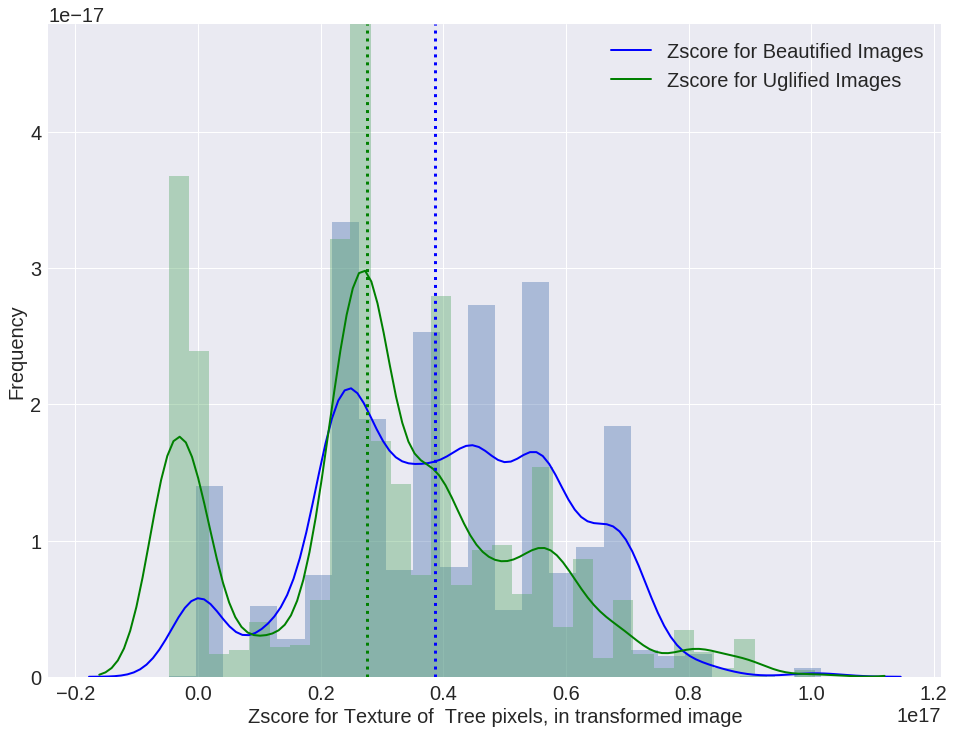

In [223]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyTextureZscore ,kde_kws={"color": "b", "lw": 2, "label": "Zscore for Beautified Images"})
sns.distplot(uglyTextureZscore , kde_kws={"color": "g", "lw": 2, "label": "Zscore for Uglified Images"})
ax.axvline(x=np.median(beautyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyTextureZscore), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')
plt.xlabel("Zscore for Texture of  " + textureLabels[dim] +  " pixels, in transformed image" , fontsize = 20)
plt.ylabel("Frequency" , fontsize = 20 )